# Irrotational random flow

**Last updated**: March 3, 2022

**Setup**

In [1]:
import numpy as np
import skimage.filters
import scipy.ndimage
import scipy.sparse

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import proplot as pplt

# Lima
import lima

In [2]:
lima.plot.init_mpl_style()

In [3]:
debug = True

In [4]:
subplotgrid = [  
    [1, 1, 2, 2, 3, 3],
    [0, 4, 4, 5, 5, 0],
]

**Functions**

In [5]:
def vortZ(u, v):
    dudy, dudx = np.gradient(u)
    dvdy, dvdx = np.gradient(v)
    return dvdx - dudy

def divUV(u, v):
    dudy, dudx = np.gradient(u)
    dvdy, dvdx = np.gradient(v)
    return dudx + dvdy

def random_dataset(vscale=1.0, height=256, width=256, filter_size=5, seed=None):
    if seed:
        np.random.seed(seed)
    # Coordinates
    x, y = np.meshgrid(np.arange(height, dtype='float32'),
                       np.arange(width, dtype='float32'))

    #u, v = np.random.rand(2, height, width).astype('float32') - 0.5
    u, v = np.random.uniform(-1, 1, size=(2, height, width)).astype('float32')
    u = skimage.filters.gaussian(u, filter_size, mode='reflect')
    v = skimage.filters.gaussian(v, filter_size, mode='reflect')
    u = u/np.abs(u).max() * vscale
    v = v/np.abs(v).max() * vscale
    # Parameters
    #print(np.max(u), np.max(v))
    return x, y, u, v

def quiver(ax, x, y, u, v, skip=1, *args, **kwargs):
    return ax.quiver(
        x[::skip, ::skip], y[::skip, ::skip], u[::skip, ::skip], v[::skip, ::skip],
        *args, **kwargs
    )

norm = lambda u,v: np.sqrt(u**2 + v**2)

In [6]:
def construct_LHS(nx, ny, h=1):
    n = nx * ny 
    B = np.zeros((5, n))

    for i in range(ny):
        for j in range(nx):
            k = j*nx + i
            if i == 0:
                if j == 0:
                    B[2, k]    =  2*h/(h + h) + 2*h/(h + h)
                    B[3, k+1]  = -2*h/(h + h)
                    B[4, k+nx] = -2*h/(h + h)
                elif j == nx-1:
                    B[0, k-nx] = -2*h/(h + h)
                    B[2, k]    =  2*h/(h + h) + 2*h/(h + h)
                    B[3, k+1]  = -2*h/(h + h)
                else:
                    B[0, k-nx] = -2*h/(h + h)
                    B[2, k]    =  2*h/(h + h) + 2*h/(h + h) + 2*h/(h + h)
                    B[3, k+1]  = -2*h/(h + h)
                    B[4, k+nx] = -2*h/(h + h)
            elif i == nx-1:
                if j == 0:
                    B[1, k-1]  = -2*h/(h + h)
                    B[2, k]    =  2*h/(h + h) + 2*h/(h + h)
                    B[4, k+nx] = -2*h/(h + h)
                elif j == nx-1:
                    B[0, k-nx] = -2*h/(h + h)
                    B[1, k-1]  = -2*h/(h + h)
                    B[2, k]    =  2*h/(h + h) + 2*h/(h + h)
                else:
                    B[0, k-nx] = -2*h/(h + h)
                    B[1, k-1]  = -2*h/(h + h)
                    B[2, k]    =  2*h/(h + h) + 2*h/(h + h) + 2*h/(h + h)
                    B[4, k+nx] = -2*h/(h + h)
            elif j == 0:
                if ( i > 0 and i < nx-1 ):
                    B[1, k-1]  = -2*h/(h + h)
                    B[2, k]    =  2*h/(h + h) + 2*h/(h + h) + 2*h/(h + h)
                    B[3, k+1]  = -2*h/(h + h)
                    B[4, k+nx] = -2*h/(h + h)
            elif j == nx-1:
                if ( i > 0 and i < nx-1 ):
                    B[0, k-nx] = -2*h/(h + h)
                    B[1, k-1]  = -2*h/(h + h)
                    B[2, k]    =  2*h/(h + h) + 2*h/(h + h) + 2*h/(h + h)
                    B[3, k+1]  = -2*h/(h + h)
            else:
                B[0, k-nx]     = -2*h/(h + h)
                B[1, k-1]      = -2*h/(h + h)
                B[2, k]        =  2*h/(h + h) + 2*h/(h + h) + 2*h/(h + h) + 2*h/(h + h)
                B[3, k+1]      = -2*h/(h + h)
                B[4, k+nx]     = -2*h/(h + h)
    
    # Diagonal indices
    diags = np.array([-nx, -1, 0, 1, nx])

    # Construct sparse diagonal matrix
    L = scipy.sparse.spdiags(B, diags, n, n).tocsr()
    return L

def construct_RHS(u, v):
    f = -divUV(u, v)
    return f.ravel()

def solve_poisson_equation(u, v, L=None, debug=False, maxiter=100):
    if L is None:
        L = construct_LHS(u.shape[0], u.shape[1])
    f = construct_RHS(u, v)
    # Solve using gmres
    phi, info = scipy.sparse.linalg.gmres(L, f, maxiter=maxiter)
    if debug:
        print(f"Residual: {np.sum(np.abs(L.dot(phi) - f))}")
    phi = phi.reshape(u.shape[0], u.shape[1])
    return phi
    
def calculate_irrotational_flow(u, v, L=None, debug=False, maxiter=100):
    # Solve poisson equation: $\nabla^2 \phi = -\nabla \cdot u$
    phi = solve_poisson_equation(u, v, L, debug, maxiter)
    
    # Calculate irrotation flow
    v_phi, u_phi = np.gradient(phi)
    
    return u_phi, v_phi

## Pure-random flow

In [7]:
filter_size = 5
vscale = 1
height = width = 64

In [8]:
# Random dist.
np.random.seed(234)

x, y, _,_ = random_dataset(vscale=1, height=height, width=width, filter_size=filter_size)
u, v = np.random.uniform(-1, 1, size=(2, height, width)).astype('float32')

# Filtered
uf = skimage.filters.gaussian(u, filter_size, mode="reflect")#, preserve_range=True) 
vf = skimage.filters.gaussian(v, filter_size, mode="reflect")#, preserve_range=True)
uf = uf/np.abs(uf).max() * vscale
vf = vf/np.abs(vf).max() * vscale
# Scaled
us = uf
vs = vf

### Rotational and irrotational component

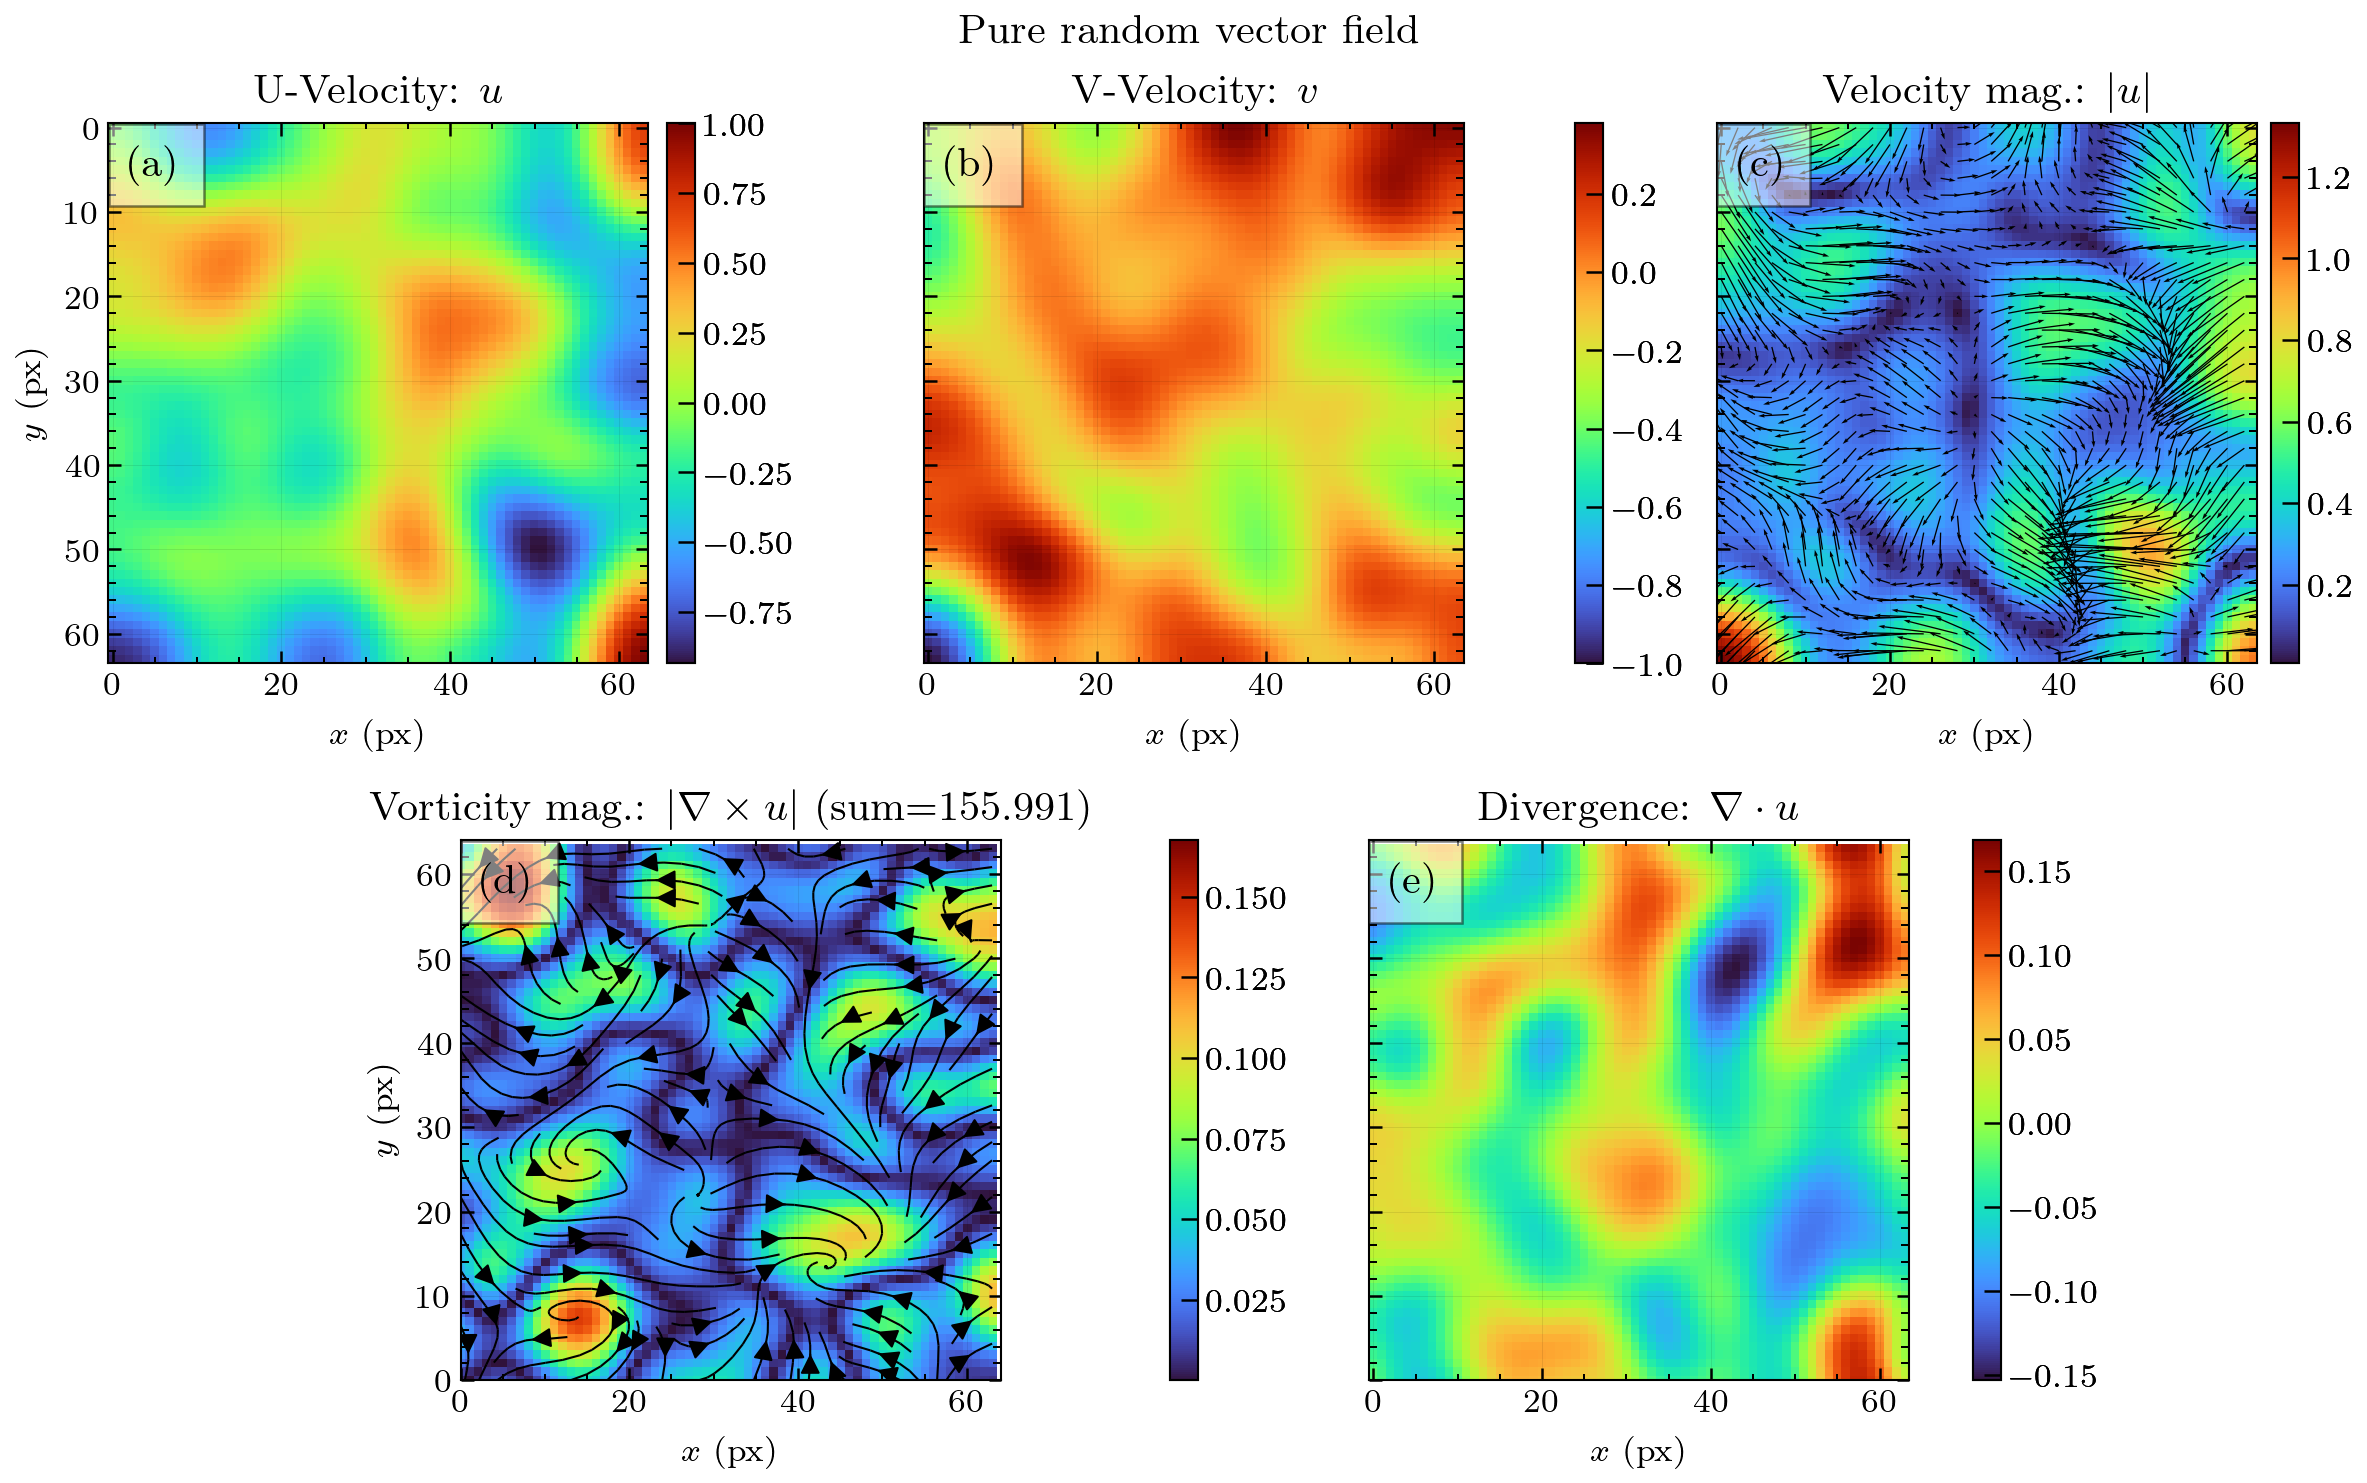

In [9]:
fig = pplt.figure(refwidth='1.8', span=False)
axes = fig.subplots(subplotgrid)

s = 5
# u
ax = axes[0]
im = ax.imshow(us,  interpolation='none', cmap='turbo')
cb = ax.colorbar(im, width='0.75em')
ax.format(title=r"U-Velocity: $u$")

# v
ax = axes[1]
im = ax.imshow(vs,  interpolation='none', cmap='turbo')
cb = ax.colorbar(im, width='0.75em')
ax.format(title=r"V-Velocity: $v$")

# |u| 
ax = axes[2]
im = ax.imshow((us**2 + vs**2)**0.5,  interpolation='none', cmap='turbo')
cb = ax.colorbar(im, width='0.75em')
quiver(ax, x, y, us, vs, skip=2, color='k', scale=s)
ax.format(title=r"Velocity mag.: $|u|$")

# vorticity |u| 
ax = axes[3]
im = ax.imshow(np.abs(vortZ(us, vs)), interpolation='none', cmap='turbo')
cb = ax.colorbar(im, width='0.75em')
ax.format(title=fr"Vorticity mag.: $|\nabla \times u|$ (sum={np.abs(vortZ(us, vs)).sum():2g})")
ax.streamplot(x, y, us, vs, c='k', lw=0.5)
ax.axis([0, height, 0, width])

# divergence |u| 
ax = axes[4]
im = ax.imshow(divUV(us, vs), interpolation='none', cmap='turbo')
cb = ax.colorbar(im, width='0.75em')
ax.format(title=r"Divergence: $\nabla \cdot u$")

# Quiver

# # Format
axes.format(
    abc='(a)', abcloc='ul', abcbbox=True,
    xlabel='$x$ (px)', ylabel='$y$ (px)',
    suptitle='Pure random vector field',
)

---
## Irrotational Flow

1. Perform helmholtz decomposition: 
$$
u = -\nabla \phi + \nabla \times \psi
$$
2. Construct poisson equation by taking divergence of velocity:
$$
\nabla \cdot u = -\nabla^2 \phi \equiv f
$$
3. Solve poisson equation using iterative method (relaxation method) or directly.
4. Calculate irrotation velocity: 
$$
u_{\phi} = -\nabla \phi
$$

**Solve discrete poisson equation**

The 2D poisson equation is:
$$
\nabla^2 \phi = f
$$
or in 2D cartesian:
$$
\frac{\partial^2 \phi}{\partial x^2} + \frac{\partial^2 \phi}{\partial y^2} = f
$$

In discretize form (central):
$$
\frac{\phi_{i+1,j} - 2\phi_{i,j} + \phi_{i-1,j}}{\Delta x^2} + \frac{\phi_{i,j+1} - 2\phi_{i,j} + \phi_{i,j-1}}{\Delta y^2} = f_{i,j}
$$

Define the discrete Laplacian, i.e., the Laplacian matrix $L$, we then need to solve the system of equation:
$$
L \phi = f
$$


### Construct the Sparse L matrix (LHS)

In [10]:
nx, ny = us.shape
L = construct_LHS(nx, ny)

**Condition number**

In [11]:
if debug:
    print(f"Condition number: {np.linalg.cond(L.todense())}!!!")

Condition number: 1.1483591666066174e+16!!!


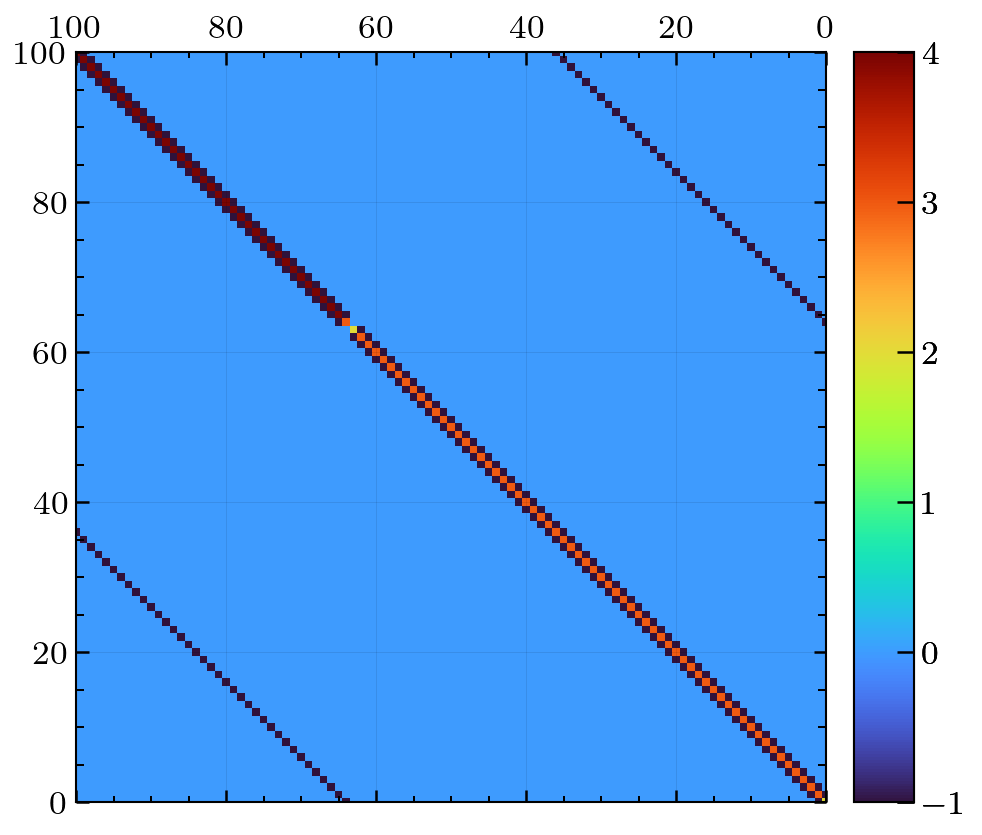

In [12]:
if debug:
    fig = pplt.figure()
    ax = fig.gca()
    im = ax.matshow(L.toarray(), cmap='turbo')
    ax.colorbar(im)
    ax.axis([100, 0, 0, 100])

### Calculate irrotational velocity

The irrotation velocity component is defined as:
$$
u_{\phi} = -\nabla \phi
$$

where
$$
\begin{aligned}
u_{x,\phi} &= \frac{\partial \phi}{\partial x}\\
u_{y,\phi} &= \frac{\partial \phi}{\partial y}
\end{aligned}
$$


In [13]:
%%time
maxiter = 200
u_phi, v_phi = calculate_irrotational_flow(us, vs, L, debug=debug, maxiter=maxiter)

Residual: 6.324544840488443
CPU times: user 847 ms, sys: 20.1 ms, total: 867 ms
Wall time: 434 ms


**Inspect vorticity**

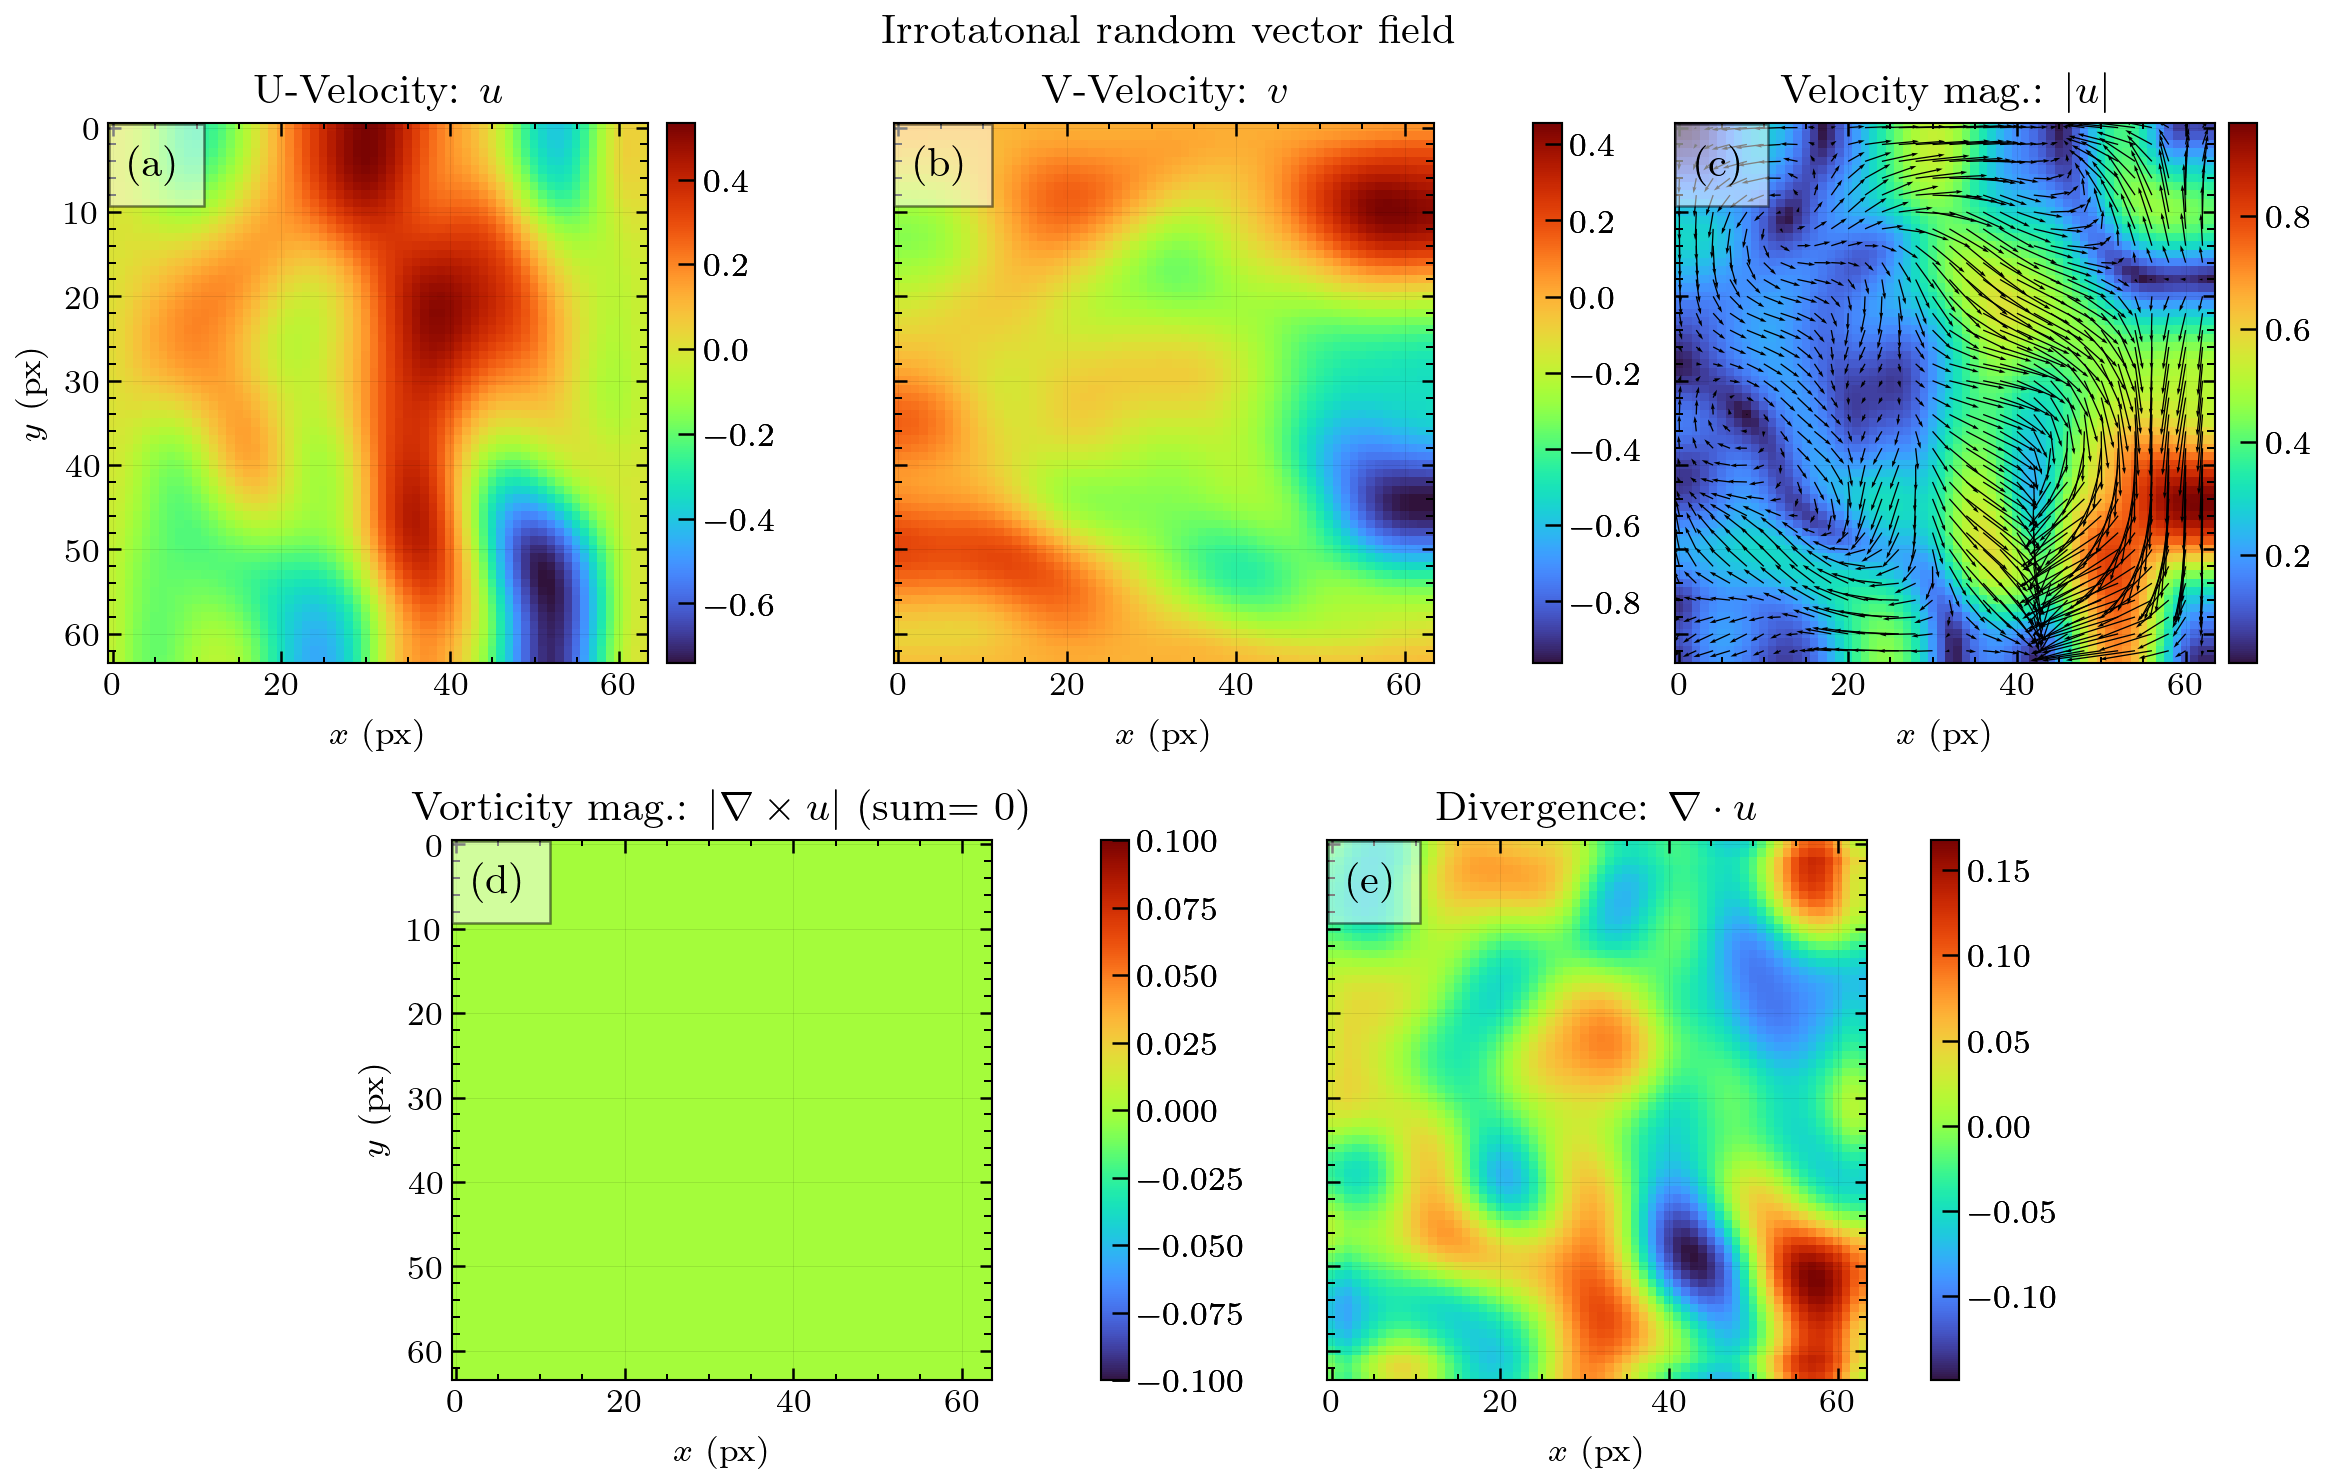

In [14]:
fig = pplt.figure(refwidth='1.8', span=False)
axes = fig.subplots(subplotgrid)

s = 5
# u
ax = axes[0]
im = ax.imshow(u_phi,  interpolation='none', cmap='turbo')
cb = ax.colorbar(im, width='0.75em')
# quiver(ax, x, y, u_phi, v_phi, skip=2, color='k', scale=s)
ax.format(title=r"U-Velocity: $u$")

# v
ax = axes[1]
im = ax.imshow(v_phi,  interpolation='none', cmap='turbo')
cb = ax.colorbar(im, width='0.75em')
# quiver(ax, x, y, u_phi, v_phi, skip=2, color='k', scale=s)
ax.format(title=r"V-Velocity: $v$")

# |u| 
ax = axes[2]
im = ax.imshow((u_phi**2 + v_phi**2)**0.5,  interpolation='none', cmap='turbo')
cb = ax.colorbar(im, width='0.75em')
quiver(ax, x, y, u_phi, v_phi, skip=2, color='k', scale=s)
ax.format(title=r"Velocity mag.: $|u|$")
# ax.streamplot(x, y, u_phi, v_phi, c='k', lw=0.5)
# ax.axis([0, height, 0, width])

# vorticity |u| 
ax = axes[3]
im = ax.imshow(np.abs(vortZ(u_phi, v_phi)), interpolation='none')
cb = ax.colorbar(im, width='0.75em')
ax.format(title=fr"Vorticity mag.: $|\nabla \times u|$ (sum={np.abs(vortZ(u_phi, v_phi)).sum():2g})")

# divergence |u| 
ax = axes[4]
im = ax.imshow(divUV(u_phi, v_phi), interpolation='none', cmap='turbo')
cb = ax.colorbar(im, width='0.75em')
ax.format(title=r"Divergence: $\nabla \cdot u$")
# ax.axis([0,64,0,64])

# Quiver

# # Format
axes.format(
    abc='(a)', abcloc='ul', abcbbox=True,
    xlabel='$x$ (px)', ylabel='$y$ (px)',
    suptitle='Irrotatonal random vector field',
)